# Gesture Recognition



In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Thumbs up: Increase the volume

Thumbs down: Decrease the volume

Left swipe: 'Jump' backwards 10 seconds

Right swipe: 'Jump' forward 10 seconds

Stop: Pause the movie

In [1]:
#importing necessary libraries

import numpy as np
import os
import scipy.misc
import PIL
from cv2 import imread,resize
import datetime
import os
import pathlib

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error

In [3]:
path = pathlib.Path.cwd()
print(path)

/home


In [4]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 20

In [5]:
train_doc[:5]

array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n'],
      dtype='<U88')

Plot one image in actual dimension

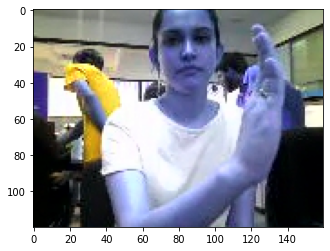

In [6]:
import matplotlib.pyplot as plt
t = np.random.permutation(train_doc)
train_path = '/datasets/Project_data/train'
imgs = os.listdir(train_path+'/'+ t[0].split(';')[0])
image = imread(train_path+'/'+ t[0].strip().split(';')[0]+'/'+imgs[1]).astype(np.float32)
plt.imshow(image.astype("uint8"))

Compressed version of same image

(120, 160, 3)
(100, 100, 3)


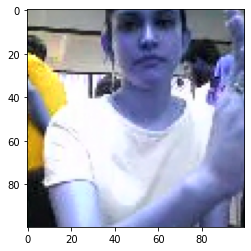

In [7]:
h,w,_ = image.shape
print(image.shape)
image3 = resize(image[int(h/2)-50:int(h/2)+50,int(w/2)-50:int(w/2)+50,:],(100,100)).astype(np.float32)
print(image3.shape)
plt.imshow(image3.astype("uint8"))

# Generator

 This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [8]:
## Generator

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,100,100,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[int(h/2)-50:int(h/2)+50,int(w/2)-50:int(w/2)+50,:],(100,100)).astype(np.float32)
                    else:
                        image = resize(image,(100,100)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0]))/(np.max(image[:,:,0])-np.min(image[:,:,0]))
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1]))/(np.max(image[:,:,1])-np.min(image[:,:,1]))
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2]))/(np.max(image[:,:,2])-np.min(image[:,:,2]))
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[int(h/2)-50:int(h/2)+50,int(w/2)-50:int(w/2)+50,:],(100,100)).astype(np.float32)
                    else:
                        image = resize(image,(100,100)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0]))/(np.max(image[:,:,0])-np.min(image[:,:,0]))
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1]))/(np.max(image[:,:,1])-np.min(image[:,:,1]))
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2]))/(np.max(image[:,:,2])-np.min(image[:,:,2]))

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


# Model

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Experiment 1: CNN + RNN based architecture with 5 epochs

In [11]:
## Experiment 1 - CNN + RNN based architecture with 5 epochs

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(18,100,100,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

2023-09-07 03:30:46.036796: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-07 03:30:46.036860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14796 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train

In [13]:

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 64)           15009664  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 18, 32)            9408      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                        

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [15]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)

else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [17]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_332/2741796141.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/5


2023-09-07 03:31:05.871252: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6425 - categorical_accuracy: 0.2021Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2023-09-0703_30_43.005262/model-00001-1.64252-0.20211-1.61456-0.15000.h5
34/34 [==============================] - 36s 852ms/step - loss: 1.6425 - categorical_accuracy: 0.2021 - val_loss: 1.6146 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 1.6195 - categorical_accuracy: 0.2021
Epoch 00002: saving model to model_init_2023-09-0703_30_43.005262/model-00002-1.61954-0.20211-1.60485-0.25000.h5
34/34 [==============================] - 28s 842ms/step - loss: 1.6195 - categorical_accuracy: 0.2021 - val_loss: 1.6048 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/5
33/34 [============================>.] - ETA: 0s - loss: 1.6069 - categorical_accuracy: 0.2303
Epoch 00003: saving model to model_init_2023-09-0703_30_43.005262/model

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

# Experiment 2: CNN + RNN with Trainable VGGnet layers for 10 epochs

In [18]:
## Experiment 2 - CNN + RNN with Trainable VGGnet layers for 10 epochs

In [19]:
split_at = 15
for layer in base_model.layers[:split_at]:
    layer.trainable= False
for layer in base_model.layers[split_at:]:
    layer.trainable=True

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(18,100,100,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [20]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 18, 32)            9408      
                                                                 
 gru_3 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 5)                 45        
                                                      

In [21]:
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 10


In [22]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [23]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_332/2741796141.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6490 - categorical_accuracy: 0.2081
Epoch 00001: saving model to model_init_2023-09-0703_30_43.005262/model-00001-1.64898-0.20814-1.58070-0.26000.h5
34/34 [==============================] - 32s 840ms/step - loss: 1.6490 - categorical_accuracy: 0.2081 - val_loss: 1.5807 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5583 - categorical_accuracy: 0.2700
Epoch 00002: saving model to model_init_2023-09-0703_30_43.005262/model-00002-1.55829-0.26998-1.53626-0.39000.h5
34/34 [==============================] - 27s 822ms/step - loss: 1.5583 - categorical_accuracy: 0.2700 - val_loss: 1.5363 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.4781 - categorical_accuracy: 0.3409
Epoch 00003: saving model to model_init_2023-09-0703_30_43.005262/model-00003-1.47813-0.34087-1.41489-0.48000.h5
34/34

# Experiment 3 - CNN + RNN with Trainable VGGnet layers for 20 epochs

In [33]:
## Experiment 3 - CNN + RNN with Trainable VGGnet layers for 20 epochs

In [24]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 20


In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [26]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_332/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.9582 - categorical_accuracy: 0.6169
Epoch 00001: saving model to model_init_2023-09-0703_30_43.005262/model-00001-0.95823-0.61689-0.92433-0.67000.h5
34/34 [==============================] - 29s 862ms/step - loss: 0.9582 - categorical_accuracy: 0.6169 - val_loss: 0.9243 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9139 - categorical_accuracy: 0.6425
Epoch 00002: saving model to model_init_2023-09-0703_30_43.005262/model-00002-0.91390-0.64253-0.86018-0.67000.h5
34/34 [==============================] - 28s 848ms/step - loss: 0.9139 - categorical_accuracy: 0.6425 - val_loss: 0.8602 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8410 - categorical_accuracy: 0.6757
Epoch 00003: saving model to model_init_2023-09-0703_30_43.005262/model-00003-0.84097-0.67572-0.89325-0.61000.h5
34/34

# Experiment 4 -CNN + RNN without trainable VGGnet layers with additional dropout for 20 epoch

In [27]:
## Experiment 4 -CNN + RNN without trainable VGGnet layers with additional dropout for 20 epoch

In [28]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(18,100,100,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [29]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_4 (GRU)                 (None, 18, 32)            9408      
                                                                 
 gru_5 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 5)                 45        
                                                      

In [30]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 20


In [31]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [32]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_332/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6326 - categorical_accuracy: 0.2036
Epoch 00001: saving model to model_init_2023-09-0703_30_43.005262/model-00001-1.63262-0.20362-1.58231-0.31000.h5
34/34 [==============================] - 31s 850ms/step - loss: 1.6326 - categorical_accuracy: 0.2036 - val_loss: 1.5823 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.6213 - categorical_accuracy: 0.2232
Epoch 00002: saving model to model_init_2023-09-0703_30_43.005262/model-00002-1.62131-0.22323-1.56488-0.32000.h5
34/34 [==============================] - 27s 808ms/step - loss: 1.6213 - categorical_accuracy: 0.2232 - val_loss: 1.5649 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.5902 - categorical_accuracy: 0.2308
Epoch 00003: saving model to model_init_2023-09-0703_30_43.005262/model-00003-1.59018-0.23077-1.56824-0.27000.h5
34/34

# Experiment 5: CNN + RNN without trainable VGGnet layers for 20 epochs

In [33]:
## Experiment 5: CNN + RNN without trainable VGGnet layers for 20 epochs

In [34]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(100,100,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(18,100,100,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [35]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru_6 (GRU)                 (None, 18, 32)            9408      
                                                                 
 gru_7 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 dense_10 (Dense)            (None, 5)                 45        
                                                      

In [36]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 20


In [37]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [38]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_332/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6410 - categorical_accuracy: 0.1931
Epoch 00001: saving model to model_init_2023-09-0703_30_43.005262/model-00001-1.64103-0.19306-1.59567-0.24000.h5
34/34 [==============================] - 30s 830ms/step - loss: 1.6410 - categorical_accuracy: 0.1931 - val_loss: 1.5957 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.6062 - categorical_accuracy: 0.2338
Epoch 00002: saving model to model_init_2023-09-0703_30_43.005262/model-00002-1.60621-0.23379-1.60026-0.21000.h5
34/34 [==============================] - 28s 831ms/step - loss: 1.6062 - categorical_accuracy: 0.2338 - val_loss: 1.6003 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.5889 - categorical_accuracy: 0.2700
Epoch 00003: saving model to model_init_2023-09-0703_30_43.005262/model-00003-1.58893-0.26998-1.58612-0.29000.h5
34/34

# Experiment 6: Conv3D architecture with 25 epochs

In [39]:
## Experiment 6: Conv3D architecture with 25 epochs

In [40]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D


model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [41]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 100, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 100, 128)   221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 50, 100, 128) 

In [42]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# epochs = 25


In [43]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [44]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_332/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 3.2418 - categorical_accuracy: 0.3529
Epoch 00001: saving model to model_init_2023-09-0703_30_43.005262/model-00001-3.24182-0.35294-2.41320-0.28000.h5
34/34 [==============================] - 34s 919ms/step - loss: 3.2418 - categorical_accuracy: 0.3529 - val_loss: 2.4132 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6019 - categorical_accuracy: 0.5339
Epoch 00002: saving model to model_init_2023-09-0703_30_43.005262/model-00002-1.60187-0.53394-5.36249-0.26000.h5
34/34 [==============================] - 28s 836ms/step - loss: 1.6019 - categorical_accuracy: 0.5339 - val_loss: 5.3625 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2860 - categorical_accuracy: 0.5928
Epoch 00003: saving model to model_init_2023-09-0703_30_43.005262/model-00003-1.28600-0.59276-7.02718-0.13000.h5

Epoc

# After doing all the experiments, we finalized Experiment 3 - CNN + RNN with Trainable VGGnet layers for 20 epochs



- (Accuracy: 0.8500)

The best weights of CNN-LSTM:model-00020-0.42394-0.95023-0.54457-0.85000.h5 Experiment 3 - CNN + RNN with Trainable VGGnet layers for 20 epochs. we considered this weight for model testing.